# Real-Time Bayesian Risk Engine (Cache-Based Workflow)

This workbook illustrates a **production-style** Python workflow for real-time Bayesian updating of
segment-level recovery probabilities using a cache (e.g., Redis). It mirrors the type of logic
you might use in production, but runs locally with an in-memory mock cache.

- We define a small event schema (repayments/defaults).
- We use a cache-like interface to store posterior parameters `(alpha, beta)` per segment.
- We implement a `BayesianRiskEngine` that updates posteriors as events arrive.
- We simulate daily claim data over time and plot posterior evolution.

In production, the cache would be a service like Redis or AWS ElastiCache; here we use a simple
Python dictionary to keep things self-contained and readable.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List

np.random.seed(42)

## Event Schema
We define a simple repayment event to simulate incoming claim outcomes.

In [16]:
@dataclass
class RepaymentEvent:
    segment_id: str  # e.g., insurer, provider group, or region
    recovered: int   # 1 = recovered, 0 = default
    amount: float    # claim amount (not strictly needed for the posterior, but realistic)
    timestamp: str   # ISO-like timestamp string for illustration

## Cache Interface (Mock Redis)
In production this would talk to Redis/ElastiCache. Here we simulate it with an in-memory dict.

In [17]:
class CacheInterface:
    def get(self, key: str):
        raise NotImplementedError

    def set(self, key: str, value):
        raise NotImplementedError


class InMemoryCache(CacheInterface):
    def __init__(self):
        self.store: Dict[str, dict] = {}

    def get(self, key: str):
        return self.store.get(key)

    def set(self, key: str, value):
        self.store[key] = value

## Bayesian Risk Engine
`BayesianRiskEngine` encapsulates the Bayesian updating logic and cache interaction.

- Each `segment_id` has a Beta prior/posterior `(alpha, beta)`.
- We update `(alpha, beta)` as new events arrive.
- We can query the posterior mean recovery probability for any segment.

In a real app, this class lives in a service that is called on each repayment/default event.

In [18]:
class BayesianRiskEngine:
    def __init__(self, cache: CacheInterface, prior_alpha: float = 2.0, prior_beta: float = 2.0):
        self.cache = cache
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta

    def _cache_key(self, segment_id: str) -> str:
        return f"segment:{segment_id}:beta_params"

    def _get_params(self, segment_id: str):
        key = self._cache_key(segment_id)
        record = self.cache.get(key)
        if record is None:
            return self.prior_alpha, self.prior_beta
        return record["alpha"], record["beta"]

    def _set_params(self, segment_id: str, alpha: float, beta: float):
        key = self._cache_key(segment_id)
        self.cache.set(key, {"alpha": alpha, "beta": beta})

    def update_segment_batch(self, segment_id: str, recoveries: np.ndarray):
        alpha, beta = self._get_params(segment_id)
        alpha_new = alpha + int(np.sum(recoveries))
        beta_new = beta + len(recoveries) - int(np.sum(recoveries))
        self._set_params(segment_id, alpha_new, beta_new)
        return alpha_new, beta_new

    def update_segment_event(self, event: RepaymentEvent):
        recoveries = np.array([event.recovered])
        return self.update_segment_batch(event.segment_id, recoveries)

    def get_posterior_mean(self, segment_id: str) -> float:
        alpha, beta = self._get_params(segment_id)
        return alpha / (alpha + beta)

## Simulation Harness (Production-Style Flow)
We now simulate an environment where multiple segments receive claim outcomes day after day.

- In production, events would be coming from a queue or stream (e.g., Kafka, Kinesis).
- Here, we simply generate synthetic events and feed them through the `BayesianRiskEngine`.
- We track posterior means over time for each segment.

Note: you could imagine this loop running inside a background worker or microservice.

In [19]:
def simulate_year(engine: BayesianRiskEngine, days: int = 60):
    segments = ["SEG_A", "SEG_B", "SEG_C"]
    true_rates = {"SEG_A": 0.60, "SEG_B": 0.50, "SEG_C": 0.70}
    claims_per_day = 500  # conceptually thousands; kept smaller for runtime

    history = {seg: [] for seg in segments}

    for day in range(days):
        for seg in segments:
            recoveries = np.random.binomial(1, true_rates[seg], size=claims_per_day)
            engine.update_segment_batch(seg, recoveries)
            mean = engine.get_posterior_mean(seg)
            history[seg].append(mean)

    return history

### Run the Simulation

In [20]:
cache = InMemoryCache()
engine = BayesianRiskEngine(cache, prior_alpha=2.0, prior_beta=2.0)
posterior_history = simulate_year(engine, days=60)
posterior_history['SEG_A'][:5]

[0.5853174603174603,
 0.5886454183266933,
 0.5857712765957447,
 0.5888223552894212,
 0.5962460063897763]

## Plot Posterior Evolution by Segment

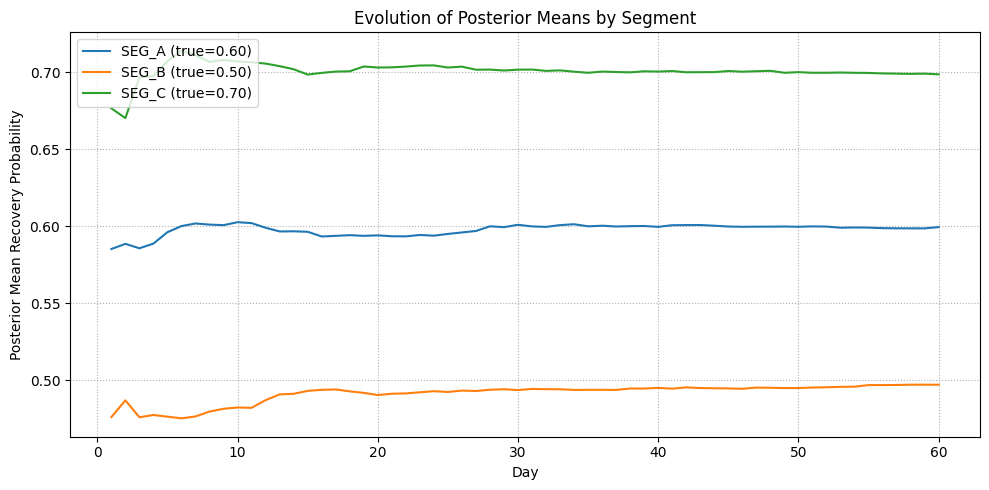

In [21]:
days = range(1, len(next(iter(posterior_history.values()))) + 1)
true_rates = {"SEG_A": 0.60, "SEG_B": 0.50, "SEG_C": 0.70}

plt.figure(figsize=(10, 5))
for seg, means in posterior_history.items():
    plt.plot(days, means, label=f"{seg} (true={true_rates[seg]:.2f})")

plt.xlabel('Day')
plt.ylabel('Posterior Mean Recovery Probability')
plt.title('Evolution of Posterior Means by Segment')
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

## How This Maps to a Production Environment

In a real system (e.g., FinTech Startup or Production):

- `InMemoryCache` would be replaced by a Redis/ElastiCache client.
- `update_segment_event` would be called by a service that consumes repayment/default events from a queue/stream.
- Periodic jobs could snapshot cache values to a persistent database for analytics and backtesting.
- Thompson Sampling or other decision logic could call `get_posterior_mean` (or sample from the Beta distribution)
  to drive dynamic credit limits, pricing, or allocation.

Here, we keep everything local and simple, but the structure (event → cache read → Bayesian update → cache write)
matches what you would do in production.